In [ ]:
!pip install pyradiomics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import matplotlib.pyplot as plt # plotting
import pandas as pd # DB
from radiomics import featureextractor
import nibabel as nib
import os
import glob
import numpy as np
from shutil import copyfile, copytree
import pickle

# you don't need this outside Google COLAB

#!pip install -U tensorboard-plugin-profile

#set up imports
#%tensorflow_version 2.x 
# previousl line only needed when working in google COLAB
import matplotlib
#matplotlib.use('Agg')
import glob
import os
import numpy as np
import nibabel as nib
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input,Conv2D, Activation, BatchNormalization, MaxPooling2D, concatenate, Conv2DTranspose, UpSampling2D, SeparableConv2D
from tensorflow.keras.layers import ZeroPadding2D,Add,ReLU,AveragePooling2D
from tensorflow.keras import metrics as mtt
from tensorflow.keras import optimizers
import math
import matplotlib.pyplot as plt

# Salta se hai già le variabili pickle

In [ ]:
import gdown

!gdown "19jGXLL7L67U2BhXT-8ZSHMWpJdlAZkfO&confirm=True"

import zipfile
with zipfile.ZipFile("brats.zip", 'r') as zip_ref:
    zip_ref.extractall("")

Downloading...
From: https://drive.google.com/uc?id=19jGXLL7L67U2BhXT-8ZSHMWpJdlAZkfO&confirm=True
To: /content/brats.zip
100% 5.49G/5.49G [01:10<00:00, 77.6MB/s]


In [ ]:
files = []

for root in os.listdir("content/GBM"):
  files.append(os.path.join("content/GBM",root))

for root in os.listdir("content/LGG"):
  files.append(os.path.join("content/LGG",root))

Magnetic Resonance Imaging (MRI) is commonly used imaging techniques for capturing images of brain tumors.By conﬁguring the MRI scanner diﬀerent modalities can be captured, such as T1-weighted (T1), T1-Post contrast-enhanced (T1ce), T2-weighted (T2), and T2-weighted ﬂuid-attenuated inversion recovery (Flair). T1 is good for seg-mentation of tumor from healthy brain tissue. T1ce has higher visibility of the tumor boundaries. In T2 the edema(ﬂuid) around the brain tumor is visible. And the Flair is suitable for identifying edema region from cerebrospinalﬂuid [3]. The MRI images can be viewed in three dimensions (Sagittal, Axial, and Coronal), which helps the medicalexperts in examining the tumors [4]. Enhancing tumor shows hyper-intensity mostly in T1-weighted. 

In [ ]:
channels = ["t1","t1ce","t2","flair"]

nPat = 50
nChan = len(channels)

In [ ]:
import random
random.seed(12345)
random.shuffle(files)

In [ ]:
for path in files:
  count = len(os.listdir(path))
  if count < 5:
    print(path)

In [ ]:
immV = np.zeros((nPat,120,120,77,nChan),dtype=np.float32)
segV = np.zeros((nPat,120,120,77,1),dtype=np.float32)

In [ ]:
for id,filepath in enumerate(files[:nPat]):
    for x, channel in enumerate(channels):
        head = nib.load(os.path.join(filepath,str(channel + ".nii.gz")))
        temp = head.get_fdata(dtype=np.float32)
        temp = temp[:,:,1:].reshape((2,120,2,120,2,77),order='F')
        immV[id,:,:,:,x] = np.mean(np.mean(np.mean(temp,axis=-2),axis=-3),axis=0)
    head = nib.load(os.path.join(filepath, "truth.nii.gz"))
    temp = head.get_fdata(dtype=np.float32)
    temp = temp[:,:,1:].reshape((2,120,2,120,2,77),order='F') 
    segV[id,:,:,:,0]= np.max(np.max(np.max(temp,axis=-2),axis=-3),axis=0)

In [ ]:
rnge = np.zeros((immV.shape[0],nChan),dtype=np.float32)
for sub in range(immV.shape[0]):
  for chan in range(nChan):
    temp = np.squeeze(immV[sub,:,:,:,chan])
    soglia = np.percentile(temp,1)
    rnge[sub,chan]=np.percentile(temp[temp>soglia],50)
rnge = rnge.reshape((immV.shape[0],1,1,1,nChan))   
immV = (immV-0.5*rnge)/rnge

(-0.5, 76.5, 119.5, -0.5)

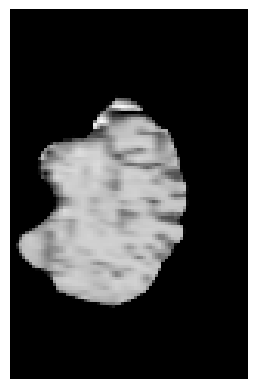

In [ ]:
plt.figure()
plt.imshow(immV[2,35,:,:,0],vmin=-0.3,vmax=1.0,cmap='Greys_r')
plt.contour(segV[2,35,:,:,0],[0.5,1.5,2.5])
plt.axis('off')

In [ ]:
# Open a file and use dump()
with open('immV.pkl', 'wb') as file:     
    # A new file will be created
    pickle.dump(immV, file)

In [ ]:
del immV
del rnge

In [ ]:
with open('segV.pkl', 'wb') as file: 
    # A new file will be created
    pickle.dump(segV, file)

In [ ]:
del segV

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
copyfile("immV.pkl","drive/MyDrive/immV.pkl")
copyfile("segV.pkl","drive/MyDrive/segV.pkl")

'drive/MyDrive/segV.pkl'

# Riprendi da qui

In [ ]:
!gdown 1SlHAQdHZlaAB41ywVnoYa9yOr51myE5w&confirm=t
!gdown 16DlqnS2j11Tls09M8HgVOPsn6BRNVqP8&confirm=t

Downloading...
From: https://drive.google.com/uc?id=1SlHAQdHZlaAB41ywVnoYa9yOr51myE5w
To: /content/immV.pkl
100% 887M/887M [00:11<00:00, 79.4MB/s]
Downloading...
From: https://drive.google.com/uc?id=16DlqnS2j11Tls09M8HgVOPsn6BRNVqP8
To: /content/segV.pkl
100% 222M/222M [00:02<00:00, 97.2MB/s]


In [ ]:
# Open the file in binary mode
with open('immV.pkl', 'rb') as file:
      
    # Call load method to deserialze
    immV = pickle.load(file)

with open('segV.pkl', 'rb') as file:
      
    # Call load method to deserialze
    segV = pickle.load(file)

In [ ]:
import tensorflow as tf

In [ ]:
nChan = 4

lowRam = 50

zeros = np.zeros((lowRam,128,128,77,nChan),dtype=np.float32)
mask = np.zeros((lowRam,128,128,77,1),dtype=np.float32)

minimo = immV.min()

zeros = np.clip(zeros, minimo,minimo)

zeros[:,:120,:120,:,:] = immV[:lowRam]
del immV
mask[:,:120,:120,:,:] = segV[:lowRam]
del segV

mask[mask>3.5]=3
mask = tf.keras.utils.to_categorical(mask)

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(zeros, mask, test_size=0.33, random_state=42)

In [ ]:
del zeros
del mask

In [ ]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(33, 128, 128, 77, 4)
(33, 128, 128, 77, 4)
(17, 128, 128, 77, 4)
(17, 128, 128, 77, 4)


In [ ]:
X_train = X_train.transpose((0,3,1,2,4))
X_train = X_train.reshape((-1,128,128,4))
y_train = y_train.transpose((0,3,1,2,4))
y_train = y_train.reshape((-1,128,128,4))

X_test = X_test.transpose((0,3,1,2,4))
X_test = X_test.reshape((-1,128,128,4))
y_test = y_test.transpose((0,3,1,2,4))
y_test = y_test.reshape((-1,128,128,4))

In [ ]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(2541, 128, 128, 4)
(2541, 128, 128, 4)
(1309, 128, 128, 4)
(1309, 128, 128, 4)


# Normal U-NET

Create a U-NET, in the most plain-vanilla configuration.

Notice how we create the "concatenation" between "encoder" and "decoder" layers

In [ ]:
from tensorflow.keras.layers import Input, Conv2D, UpSampling2D, concatenate, MaxPooling2D
from tensorflow.keras import Model

In [ ]:
inputL = Input([X_train.shape[1],X_train.shape[2],nChan])
## Encoder section
# 120x120 resolution layers
c1 = Conv2D(16,3,activation='relu',padding='same') (inputL)
c2 = Conv2D(16,3,activation='relu',padding='same') (c1)

c3 = MaxPooling2D() (c2) # 60x60
c4 = Conv2D(32,3,activation='relu',padding='same') (c3)
c5 = Conv2D(32,3,activation='relu',padding='same') (c4)

c6 = MaxPooling2D() (c5) #30x30
c7 = Conv2D(64,3,activation='relu',padding='same') (c6)
c8 = Conv2D(64,3,activation='relu',padding='same') (c7)

c9 = MaxPooling2D() (c8) #15x15
## Bridge
# "low resolution" high abstraction layer
c10 = Conv2D(128,3,activation='relu',padding='same') (c9)
c11 = Conv2D(128,3,activation='relu',padding='same') (c10)
c12 = Conv2D(128,3,activation='relu',padding='same') (c11)
c13 = UpSampling2D() (c12) #30x30

## "Decoder" network
# upsample the output and concatenate it to the encoder layer at the same resolution
c14 = concatenate([c13,c8])
c15 = Conv2D(64,3,activation='relu',padding='same') (c14)
c16 = Conv2D(64,3,activation='relu',padding='same') (c15)

c17 = UpSampling2D() (c16) #60x60
c18 = concatenate([c17,c5])
c19 = Conv2D(32,3,activation='relu',padding='same') (c18)
c20 = Conv2D(32,3,activation='relu',padding='same') (c19)

c21 = UpSampling2D() (c20) #120x120
c22 = concatenate([c21,c2])
c23 = Conv2D(16,3,activation='relu',padding='same') (c22)
c24 = Conv2D(16,3,activation='relu',padding='same') (c23)

# Output layer. We have 4 classes as output (0: background + 3 types of tumor)
# Therefore we use a softmax activation and 4 channels of output
outL = Conv2D(4,3,activation='softmax',padding='same')(c24)
model = Model(inputs=inputL,outputs=outL)

In [ ]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 128, 128, 4  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_16 (Conv2D)             (None, 128, 128, 16  592         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_17 (Conv2D)             (None, 128, 128, 16  2320        ['conv2d_16[0][0]']              
                                )                                                           

### Define the "dice accuracy" metric

We compute the dice metric, but only for the classes of interest (the background is very large so the dice is generally almost always >99.9%)

In [ ]:
from tensorflow.python.ops import math_ops
def dice_accuracy(y_true, y_pred):

  y_true = math_ops.cast(y_true[:,:,:,1:] > 0.5, y_pred.dtype)
  y_pred = math_ops.cast(y_pred[:,:,:,1:] > 0.5, y_pred.dtype)
  intersec = y_true*y_pred
  union = y_true+y_pred
#  print(K.sum(intersec,axis=[1,2]))
  dicePat = (1+2*K.sum(intersec,axis=[1,2]))/(1+K.sum(union,axis=[1,2]))
#  print(dicePat.eval)
  return K.mean(dicePat)
  

### Define the optimizer and compile the model

In [ ]:
optim = optimizers.Adam(learning_rate=1e-3)
model.compile(optimizer=optim,loss='categorical_crossentropy',metrics= [dice_accuracy])

#### Fit the model

In [ ]:
fitHist = model.fit(X_train,y_train,validation_data=(X_test,y_test),batch_size=14,epochs=60)

Epoch 1/60
182/182 [==============================] - 14s 51ms/step - loss: 0.0755 - dice_accuracy: 0.6737 - val_loss: 0.0214 - val_dice_accuracy: 0.7383
Epoch 2/60
182/182 [==============================] - 7s 41ms/step - loss: 0.0279 - dice_accuracy: 0.6953 - val_loss: 0.0192 - val_dice_accuracy: 0.7549
Epoch 3/60
182/182 [==============================] - 8s 43ms/step - loss: 0.0213 - dice_accuracy: 0.7429 - val_loss: 0.0145 - val_dice_accuracy: 0.8050
Epoch 4/60
182/182 [==============================] - 8s 42ms/step - loss: 0.0191 - dice_accuracy: 0.7697 - val_loss: 0.0141 - val_dice_accuracy: 0.8102
Epoch 5/60
182/182 [==============================] - 8s 43ms/step - loss: 0.0161 - dice_accuracy: 0.7957 - val_loss: 0.0154 - val_dice_accuracy: 0.7861
Epoch 6/60
182/182 [==============================] - 8s 43ms/step - loss: 0.0149 - dice_accuracy: 0.8086 - val_loss: 0.0137 - val_dice_accuracy: 0.8114
Epoch 7/60
182/182 [==============================] - 8s 43ms/step - loss: 0.0137

### Plot the fitting history metrics

In [ ]:
pd.DataFrame.from_dict(fitHist.history).to_csv("unet_hist.csv")

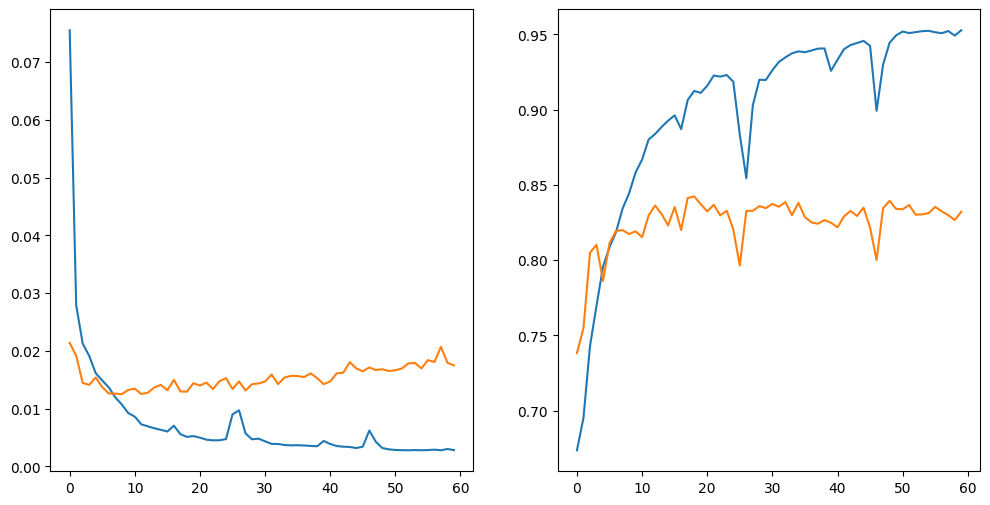

In [ ]:
plt.figure(figsize=(12,6))
plt.subplot(121)
plt.plot(fitHist.history['loss'])
plt.plot(fitHist.history['val_loss'])
plt.subplot(122)
plt.plot(fitHist.history['dice_accuracy'])
plt.plot(fitHist.history['val_dice_accuracy'])


## Compute DICE scores in BRATS categories:

BRATS computes dice scores on 
1. Whole tumor (1+2+4)
2. Core (2+4)
3. Active (4)

Remember we renamed 4 as 3


In [ ]:
def diceFromMap(map1,map2):
    unionLab = np.sum(map1) +np.sum(map2)
    interLab = np.sum(map1 & map2, dtype=np.float32)
    return (2*interLab+.1)/(unionLab+.1)
def computeDices (yPred,yTrue):
    yPred = np.asarray(yPred)
    yTrue = np.asarray(yTrue)
    if np.sum(yTrue[:,:,:,1:])<1:
        return(np.nan,np.nan,np.nan)
    diceWhole = diceFromMap(np.sum(yPred[:,:,:,1:],axis=-1)>np.sum(yPred[:,:,:,:1],axis=-1),
                            np.sum(yTrue[:,:,:,1:],axis=-1)>np.sum(yTrue[:,:,:,:1],axis=-1))
    diceCore = diceFromMap(np.sum(yPred[:,:,:,2:],axis=-1)>np.sum(yPred[:,:,:,:2],axis=-1),
                           np.sum(yTrue[:,:,:,2:],axis=-1)>np.sum(yTrue[:,:,:,:2],axis=-1))
    diceEnh = diceFromMap(np.sum(yPred[:,:,:,3:],axis=-1)>np.sum(yPred[:,:,:,:3],axis=-1),
                          np.sum(yTrue[:,:,:,3:],axis=-1)>np.sum(yTrue[:,:,:,:3],axis=-1))
    return (diceWhole,diceCore,diceEnh)

We "unstacked" 77 slices for each subject. Therefore we can compute the following way the dice for each subject (and not for each slice, as it would be ill-defined)

In [ ]:
nTestPat = 20
diceV = np.zeros((20,3))
for idx in range(20):
    yPred = model(X_test[idx*77:(idx+1)*77,:,:,:])
    diceV[idx,:]=np.array(computeDices(yPred,y_test[idx*77:(idx+1)*77,:,:,:]))

Whole Dice: mean = nan% Median = nan%
Core Dice: mean = nan% Median = nan%
Active Dice: mean = nan% Median = nan%


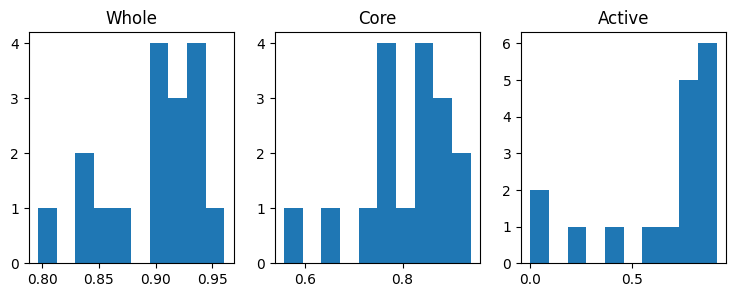

In [ ]:
plt.figure(figsize=(9,3))
titleList = ['Whole','Core','Active']
for i in range(3):
    plt.subplot(1,3,i+1)
    _=plt.hist(diceV[:,i])
    plt.title(titleList[i])
for i in range(3):
    outStr = titleList[i] + ' Dice: mean = {:.1f}% Median = {:.1f}%'    
    print(outStr.format(np.mean(diceV[:,i]*100),np.median(diceV[:,i]*100)))

In [ ]:
model.save("unet.h5")